In [1]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc , asc , udf , sum as Fsum
from pyspark.sql.types import StringType , IntegerType

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:

configure = SparkConf().setAppName("Sparkify-Data").setMaster("local")
sc = SparkContext(conf = configure)

spark = SparkSession \
        .builder \
        .appName("Sparkify-Data") \
        .getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1590192339275'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'Sparkify-Data'),
 ('spark.driver.port', '50400'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'DESKTOP-I7971JS')]

In [3]:
path = "data/sparkify_data/mini_sparkify_event_data.json"

user_log = spark.read.json(path)

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [7]:
user_log.count()

286500

In [13]:
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [16]:
user_log.select(["userId","firstname","page","song"]).where(user_log.userId == '102').collect()

[Row(userId='102', firstname='Justin', page='NextSong', song='Heads Will Roll'),
 Row(userId='102', firstname='Justin', page='NextSong', song='Bridge To Better Days'),
 Row(userId='102', firstname='Justin', page='Roll Advert', song=None),
 Row(userId='102', firstname='Justin', page='NextSong', song='Vanilla Twilight'),
 Row(userId='102', firstname='Justin', page='NextSong', song='Super Trouper'),
 Row(userId='102', firstname='Justin', page='NextSong', song='Celebration'),
 Row(userId='102', firstname='Justin', page='NextSong', song='Seven Nation Army'),
 Row(userId='102', firstname='Justin', page='NextSong', song='Verde Que Te Quero Rosa'),
 Row(userId='102', firstname='Justin', page='NextSong', song='Long_ Long Time Ago'),
 Row(userId='102', firstname='Justin', page='Roll Advert', song=None),
 Row(userId='102', firstname='Justin', page='NextSong', song='Starstruck'),
 Row(userId='102', firstname='Justin', page='Thumbs Up', song=None),
 Row(userId='102', firstname='Justin', page='NextS

In [17]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
user_log = user_log.withColumn("hour",get_hour(user_log.ts))

In [18]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='5')

In [27]:
_hour = user_log.filter(user_log.page == "NextSong").groupBy(user_log.hour).count().orderBy(user_log.hour.cast("float"))
_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|10930|
|   1|10856|
|   2|10458|
|   3|10122|
|   4| 9630|
|   5| 9062|
|   6| 8388|
|   7| 8336|
|   8| 8355|
|   9| 8147|
|  10| 8178|
|  11| 8054|
|  12| 8091|
|  13| 8253|
|  14| 8498|
|  15| 8882|
|  16| 8830|
|  17| 9326|
|  18| 9644|
|  19|10494|
+----+-----+
only showing top 20 rows



In [28]:
song_in_hour_pd = _hour.toPandas()

Text(0, 0.5, 'Song Played')

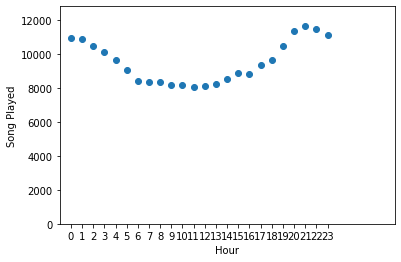

In [35]:
plt.scatter(song_in_hour_pd["hour"],song_in_hour_pd["count"])
plt.xlim(-1,29)
plt.ylim(0,1.1*max(song_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Song Played")

In [36]:
user_log_valid = user_log.dropna(how="any",subset=["userId","sessionId"])
user_log_valid.count()

286500

In [37]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [38]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
user_log_valid.count()

278154

In [39]:
#User who requested downGrade of their Account
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  16|
|  null|Logged In|   Calvin|     M|           17| Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38| 

In [40]:
user_log.select(["firstname","page","level","song"]).where(user_log.userId == '131').show()

+---------+---------------+-----+--------------------+
|firstname|           page|level|                song|
+---------+---------------+-----+--------------------+
|     Kael|       NextSong| free|       Fade To Black|
|     Kael|       NextSong| free|   Nothingman (Live)|
|     Kael|       NextSong| free|          Fuck Kitty|
|     Kael|       NextSong| free|      Half The Truth|
|     Kael|       NextSong| free|(You Make Me Feel...|
|     Kael|       NextSong| free|       Feel The Beat|
|     Kael|       NextSong| free|                Luno|
|     Kael|       NextSong| free|          Angie Baby|
|     Kael|       NextSong| free|Robot Soul (Radio...|
|     Kael|       NextSong| free|          Without Me|
|     Kael|       NextSong| free|         Close To Me|
|     Kael|       NextSong| free|Don't Take My Lov...|
|     Kael|       NextSong| free|             So Sick|
|     Kael|       NextSong| free|         Bust A Move|
|     Kael|       NextSong| free|  Sugar Candy Kisses|
|     Kael

In [43]:
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0,IntegerType())
user_log_valid = user_log_valid.withColumn("downGraded",flag_downgrade_event("page"))
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='5', downGraded=0)

In [44]:
from pyspark.sql import Window

In [46]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding,0)

In [47]:
user_log_valid = user_log_valid.withColumn("phase",Fsum("downGraded").over(windowval))

In [51]:
user_log_valid.select(["firstname","page","level","song","phase"]).where(user_log.userId == '131').sort("ts").show()

+---------+---------------+-----+--------------------+-----+
|firstname|           page|level|                song|phase|
+---------+---------------+-----+--------------------+-----+
|     Kael|       NextSong| free|       Fade To Black|    2|
|     Kael|       NextSong| free|   Nothingman (Live)|    2|
|     Kael|       NextSong| free|          Fuck Kitty|    2|
|     Kael|       NextSong| free|      Half The Truth|    2|
|     Kael|       NextSong| free|(You Make Me Feel...|    2|
|     Kael|       NextSong| free|       Feel The Beat|    2|
|     Kael|       NextSong| free|                Luno|    2|
|     Kael|       NextSong| free|          Angie Baby|    2|
|     Kael|       NextSong| free|Robot Soul (Radio...|    2|
|     Kael|       NextSong| free|          Without Me|    2|
|     Kael|       NextSong| free|         Close To Me|    2|
|     Kael|       NextSong| free|Don't Take My Lov...|    2|
|     Kael|       NextSong| free|             So Sick|    2|
|     Kael|       NextSo